In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/msc-thesis/core'))

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
from jax import vmap
from glob import glob
from tqdm.auto import tqdm
import itertools
import models, datasets, distributions, utils

In [4]:
# load dataset
ds_name = 'cifar10'
x_train, y_train, n_classes = datasets.load(ds_name, 'train')
x_test,  y_test,  n_classes = datasets.load(ds_name, 'test')

In [5]:
%%time
def get_metrics(logits, y):
    logprobs = utils.average_predictions(logits)
    acc = float((logprobs.argmax(1) == y).mean())
    avg_conf = float((jax.nn.softmax(logits).max(-1)).mean())
    return acc, avg_conf

# load all models into pandas dataframe
df = []
weights_dir = os.path.expanduser('~/Downloads/weights_cold')
for model_dir in tqdm(glob(f'{weights_dir}/*seed=0')):

    # this model is used for testing ensemble size -> skip it here
    if 'norm-scale=0.3_' in model_dir: continue
    
    # get model config
    model_name = model_dir.rsplit('/', 1)[1]
    config = {x.split('=')[0]:x.split('=')[1] for x in model_name.split('_')}
    likelihood, like_param = config['likelihood'].split('-')
    config['likelihood'] = likelihood
    config['like_param'] = float(like_param)
    config['norm_scale'] = float(config['norm-scale']); del config['norm-scale']
    config['temp'] = float(config['T']); del config['T']
    config['augment'] = config['augment'] == 'True'
    config['lr'] = float(config['lr'])
    config['seed'] = int(config['seed'])

    # load data for all seeds
    chain = []
    logits_train = []
    logits_valid = []
    for i in itertools.count():
        seed_dir = f'{model_dir[:-1]}{i}'
        if not os.path.isdir(seed_dir): break
        chain += [jnp.load(f'{seed_dir}/chain.npy')]
        logits_train += [jnp.load(f'{seed_dir}/logits_train.npy')]
        logits_valid += [jnp.load(f'{seed_dir}/logits_valid.npy')]
    chain = jnp.concatenate(chain)
    logits_train = jnp.concatenate(logits_train)
    logits_valid = jnp.concatenate(logits_valid)

    # compute metrics
    acc_train, conf_train = get_metrics(logits_train, y_train)
    acc_valid, conf_valid = get_metrics(logits_valid, y_test)
    weights_norm = float(jnp.sqrt((chain**2).mean())) # for easier interpretability, we compute the standard deviation instead of norm
    # weights_norm = float(jnp.linalg.norm(chain, axis=1).mean())
    ens_size = len(chain)

    # save model to dataframe
    df += [{**config, **dict(acc_train=acc_train, acc_valid=acc_valid, conf_train=conf_train, weights_norm=weights_norm, ens_size=ens_size)}]
    
df = pd.DataFrame.from_dict(df)
df = df.sort_values(by=['likelihood', 'like_param', 'norm_scale', 'temp'], ascending=[False, True, True, True])
df

  0%|          | 0/494 [00:00<?, ?it/s]

CPU times: user 1min 26s, sys: 19.4 s, total: 1min 46s
Wall time: 43.8 s


,model,ds,likelihood,augment,lr,seed,like_param,norm_scale,temp,acc_train,acc_valid,conf_train,weights_norm,ens_size
392,resnet20,cifar10,dirichlet,True,0.0002,0,0.990,0.1,1.0000,0.29822,0.3041,0.367405,0.310075,8
75,resnet20,cifar10,dirichlet,True,0.0002,0,0.991,0.1,1.0000,0.28606,0.2883,0.453209,460.686981,8
349,resnet20,cifar10,dirichlet,True,0.0002,0,0.992,0.1,1.0000,0.30748,0.2956,0.339022,0.323617,8
95,resnet20,cifar10,dirichlet,True,0.0002,0,0.993,0.1,1.0000,0.34008,0.3252,0.366081,0.383337,8
245,resnet20,cifar10,dirichlet,True,0.0002,0,0.994,0.1,1.0000,0.38330,0.3639,0.385481,0.253822,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,resnet20,cifar10,categorical,False,0.0104,0,0.000,3.0,0.2683,1.00000,0.8656,0.990895,0.850341,16
449,resnet20,cifar10,categorical,False,0.0104,0,0.000,3.0,0.5179,1.00000,0.8658,0.979170,1.140090,16
460,resnet20,cifar10,categorical,True,0.0104,0,0.000,3.0,0.5179,0.96000,0.9103,0.905205,1.137489,16
211,resnet20,cifar10,categorical,False,0.0104,0,0.000,3.0,1.0000,0.99236,0.8653,0.925188,1.542662,16


In [6]:
# print best model
i = df.acc_valid.to_numpy().argmax()
df.iloc[i:i+1]

,model,ds,likelihood,augment,lr,seed,like_param,norm_scale,temp,acc_train,acc_valid,conf_train,weights_norm,ens_size
90,resnet20,cifar10,categorical,True,0.0104,0,0.0,0.52,0.0001,1.0,0.9486,0.997339,0.097707,16


# Experiments: Normal prior

In [7]:
df_subset = df[(df.model=='resnet20') & (df.ds=='cifar10') & (df.likelihood=='categorical')]
scales = jnp.unique(df_subset.norm_scale.to_numpy()) # [0.05, 0.07, 0.09, 0.12, 0.16, 0.22, 0.29, 0.39, 0.52, 0.70, 0.93, 1.25, 1.67, 2.24, 3.00]
temps = jnp.unique(df_subset.temp.to_numpy()) # [0, 0.0001, 0.0002, 0.0004, 0.0007, 0.0014, 0.0027, 0.0052, 0.0100, 0.0193, 0.0373, 0.0720, 0.1389, 0.2683, 0.5179, 1.0000]
df_aug = df_subset[df_subset.augment==True]
df_noaug = df_subset[df_subset.augment==False]

## image plots

In [8]:
def remove_zeros(x, decimals=4):
    """
    Rounds and removes zeros:
    100.0001 -> 100
    1.000001 -> 1
    0.100001 -> 0.1
    """
    x = np.round(float(x), decimals=decimals)
    s = str(x)
    if s[-2:] == '.0': s = s[:-2]
    return s

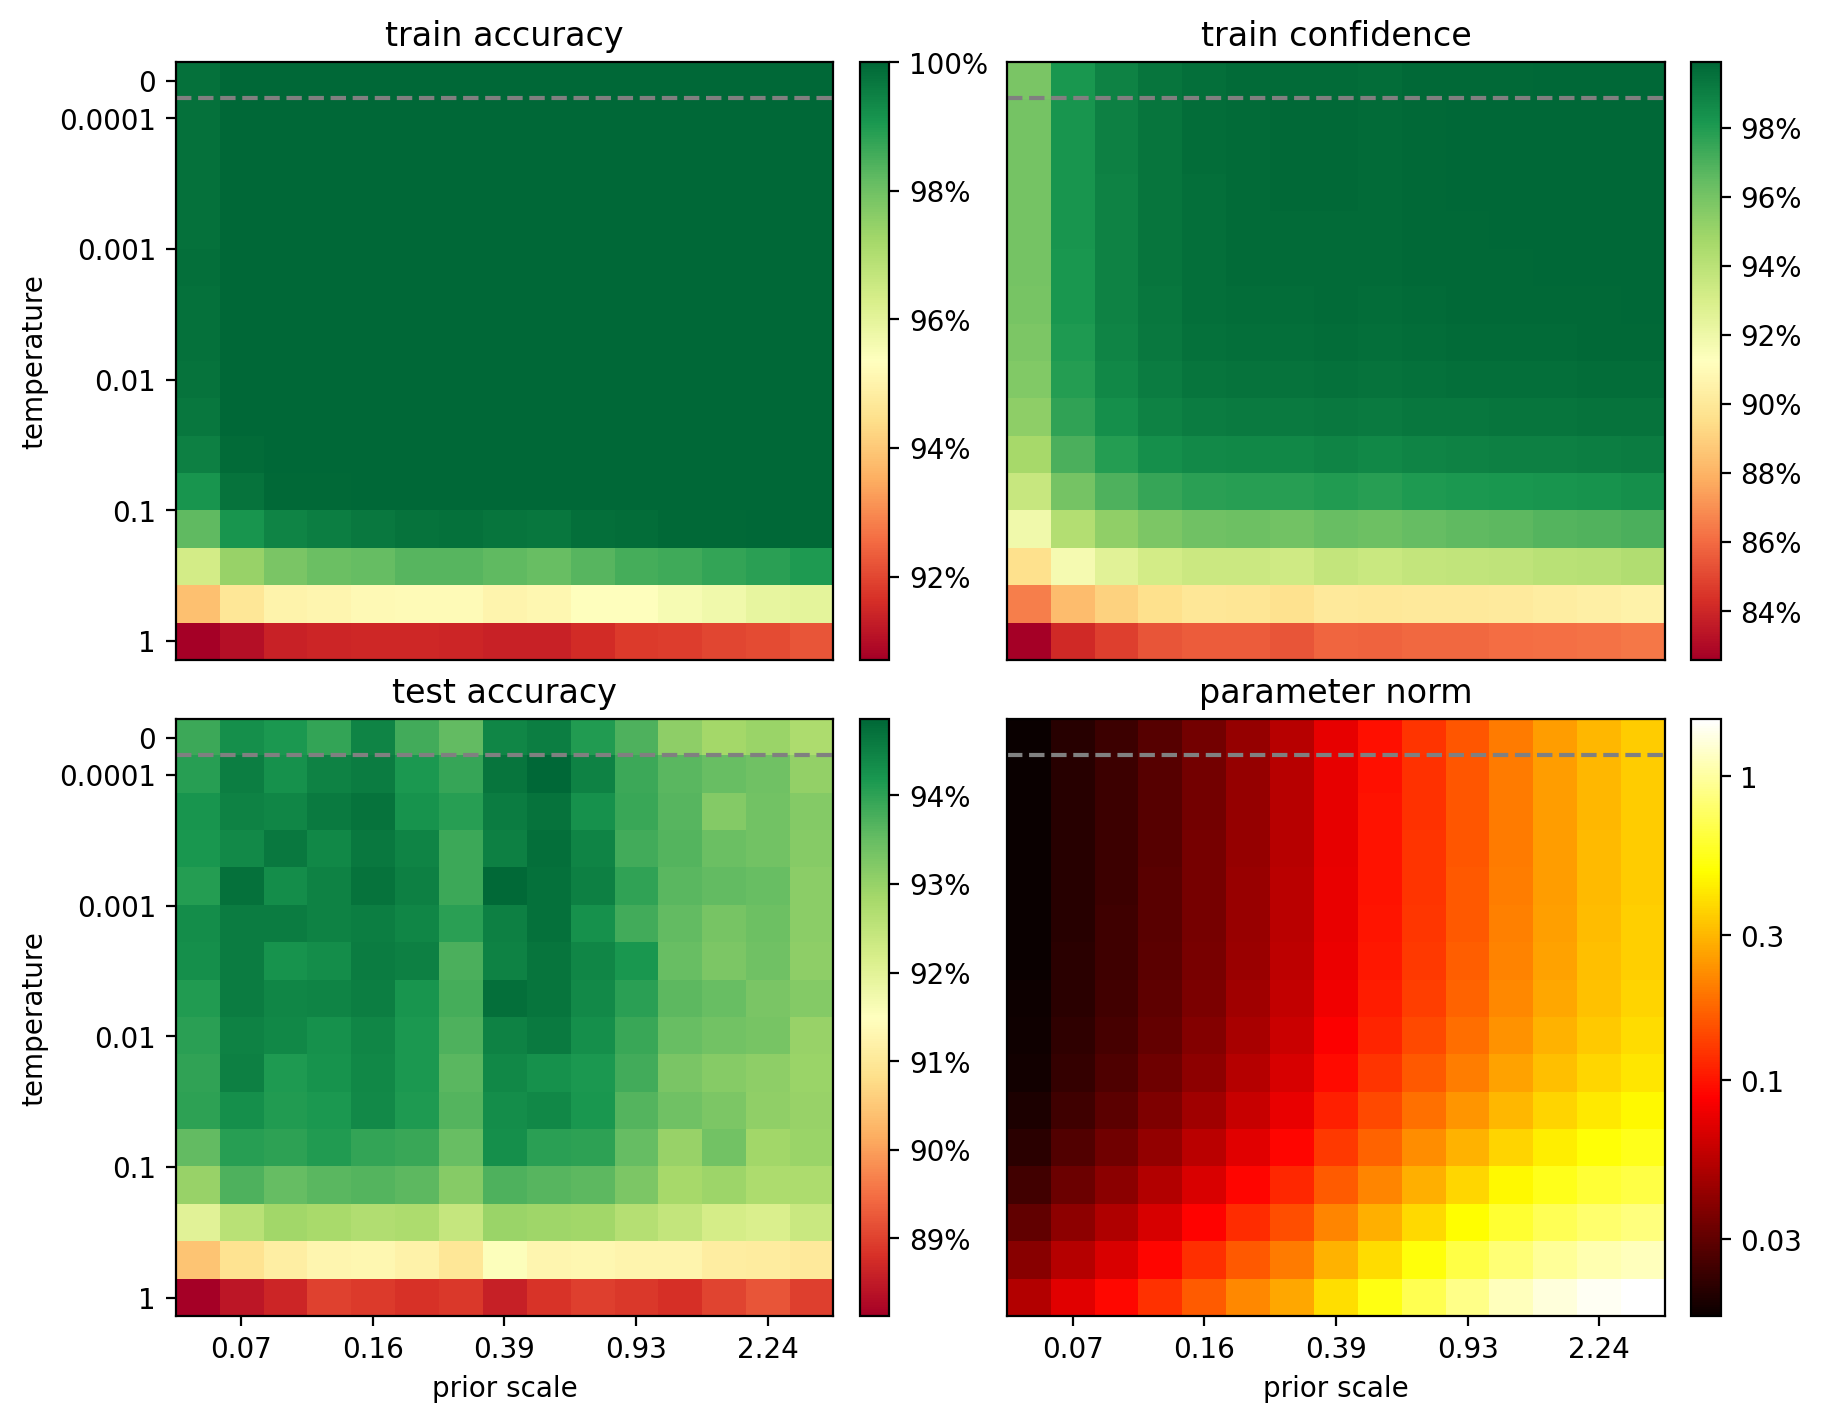

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7), layout='compressed')
im_kwargs = dict(aspect='auto')
colorbar_kwargs = dict(fraction=0.046, pad=0.04)
df_subset = df_aug
    
# load data
conf_train = np.zeros([len(scales), len(temps)])
acc_train = np.zeros([len(scales), len(temps)])
acc_valid = np.zeros([len(scales), len(temps)])
weight_norm = np.zeros([len(scales), len(temps)])
for row in df_subset.itertuples():
    i1 = jnp.searchsorted(scales, row.norm_scale)
    i2 = jnp.searchsorted(temps, row.temp)
    conf_train[i1, i2] = row.conf_train
    acc_train[i1, i2] = row.acc_train
    acc_valid[i1, i2] = row.acc_valid
    weight_norm[i1, i2] = row.weights_norm
    
# train accuracy
ax = axs[0, 0]
im = ax.imshow(acc_train.T, cmap='RdYlGn', **im_kwargs)
fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
ax.set_title('train accuracy')

# train confidence
ax = axs[0, 1]
im = ax.imshow(conf_train.T, cmap='RdYlGn', **im_kwargs)
fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
ax.set_title('train confidence')

# valid accuracy
ax = axs[1, 0]
im = ax.imshow(acc_valid.T, cmap='RdYlGn', **im_kwargs)
fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: f'{x:.0%}')
ax.set_title('test accuracy')

# weights norm
ax = axs[1, 1]
im = ax.imshow(jnp.log(weight_norm.T), cmap='hot', **im_kwargs)
cbar = fig.colorbar(im, ax=ax, **colorbar_kwargs, format=lambda x, _: remove_zeros(jnp.exp(x)))
cbar.set_ticks(jnp.log(jnp.array([1, 0.3, 0.1, 0.03])))
ax.set_title('parameter norm')

# manually add logarithmic tick values
for ax in axs.flatten():
    ax.set_xticks(np.arange(len(scales))[1::3])
    ax.set_xticklabels(scales[1::3])
    ax.set_yticks((0, *np.linspace(1, len(temps)-1, 5)), ('0', '0.0001', '0.001', '0.01', '0.1', '1'), rotation=0)
    ax.axhline(y=0.45, c='gray', ls='--')

# label axes
for ax in axs[:, 0]: ax.set_ylabel('temperature')
for ax in axs[1, :]: ax.set_xlabel('prior scale')

# hide x and y axes inside figure
for ax in axs[0, :]:
    ax.set(xticklabels=[])
    ax.tick_params(bottom=False)
for ax in axs[:, 1]:
    ax.set(yticklabels=[])
    ax.tick_params(left=False)

plt.savefig('../plots/temp_scale_grid.pdf')
plt.show()

# prior vs. posterior
compare confidence of prior *samples* to posterior *samples*

In [17]:
# these experiments were run with an older version of the codebase, which stored parameters as arrays (instead of trees)
# this function converts models that use tree parameters to models that use array parameters
import haiku as hk
from jax.flatten_util import ravel_pytree

def make_flattened_predict_fn(net, params_sample):
    params, unravel_fn = ravel_pytree(params_sample)

    @jax.jit
    def predict_fn(x, params):
        params = unravel_fn(params)
        y_hat, _ = net.apply(params, None, x)
        return y_hat
    
    return params, predict_fn

# load model
key = jax.random.PRNGKey(0)
net_fn = models.make_resnet20_fn(n_classes)
net = hk.transform(net_fn)
params = net.init(key, x_train[:1])
params, predict_fn = make_flattened_predict_fn(net, params)

In [18]:
df_subset = df_aug
scale = df_subset.weights_norm.to_numpy()
temp = df_subset.temp.to_numpy()
effective_scale = scale * jnp.sqrt(temp)
post_norm = df_subset.weights_norm.to_numpy()
post_conf = df_subset.conf_train.to_numpy()

In [19]:
%%time
# get prior confidence
key = jax.random.PRNGKey(0)
_, n_params = chain.shape
n_models = 10
params_std_normal = jax.random.normal(key, [n_models, n_params])

def get_prior_conf(std):
    # for each model, predict class of each image
    params = std * params_std_normal # [n_models, n_params]
    logits = jax.vmap(predict_fn, (None, 0))(x_train[:100], params) # [n_models, n_train, n_classes]
    y_hat = jax.nn.softmax(logits) # [n_models, n_train, n_classes]

    # compute the confidence for each model independently
    prior_conf = y_hat.max(2) # [n_models, n_train]

    # average prediction confidence over models and images
    return prior_conf.mean()

prior_scale = jnp.geomspace(1e-4, 2, 100)
prior_conf = jax.lax.map(get_prior_conf, prior_scale)
print(prior_conf[0])

0.10001799
CPU times: user 6min 14s, sys: 19.9 s, total: 6min 34s
Wall time: 1min 6s


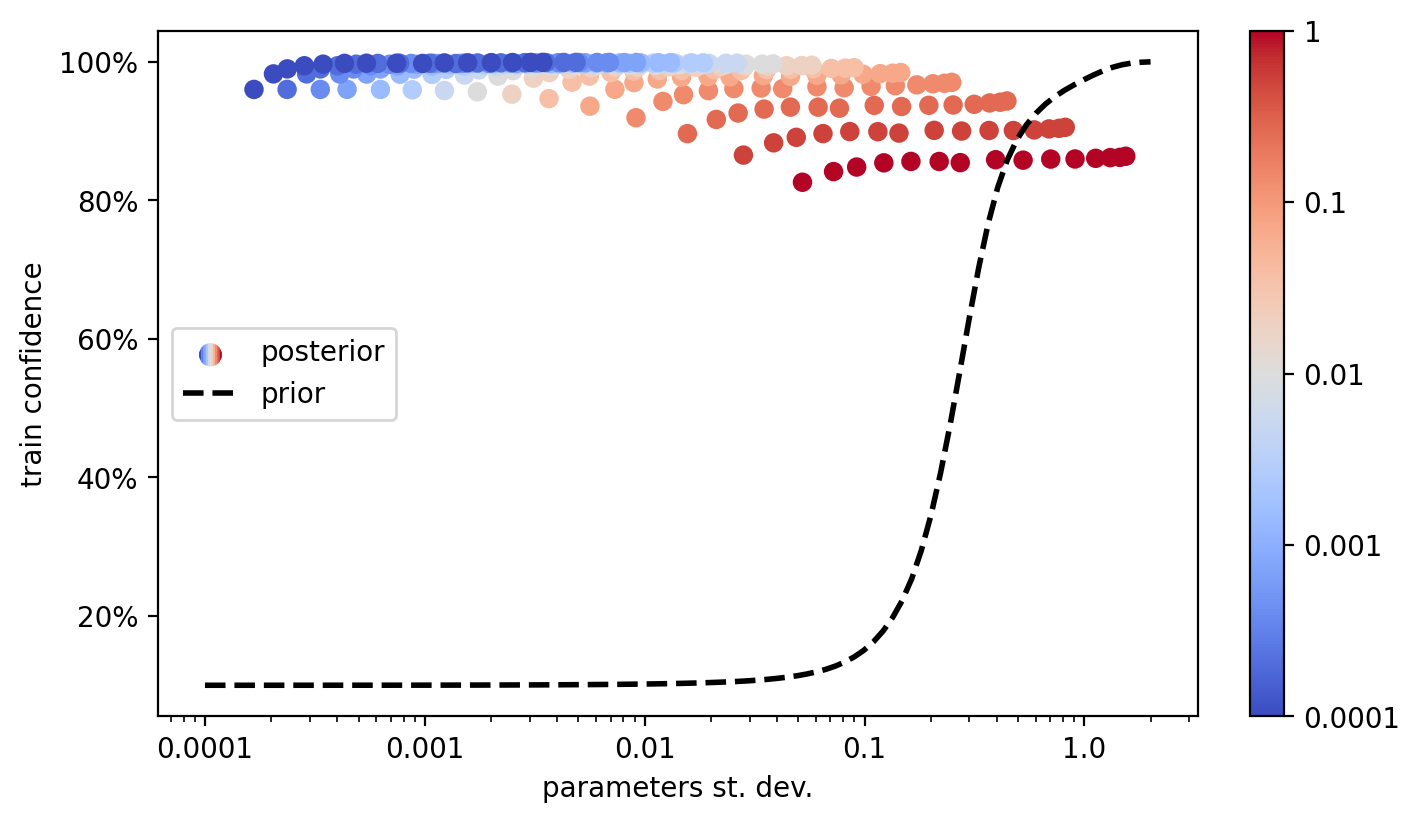

In [20]:
fig, ax = plt.subplots(figsize=(7, 4), layout='compressed')

# prior confidence
ax.plot(prior_scale, prior_conf, color='black', ls='--', lw=2, label='prior')

# posterior confidence
cmap = 'coolwarm'
color_norm = mpl.colors.Normalize(vmin=jnp.log(temp[temp>0]).min(), vmax=jnp.log(temp).max(), clip=True)
color_mapper = mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap)
c = color_mapper.to_rgba(jnp.log(temp))
ax.scatter(effective_scale, post_conf, c=c)
# plt.colorbar(color_mapper, ax=ax, format=lambda x, _: f'{jnp.exp(x):.4f}')
cbar = fig.colorbar(color_mapper, ax=ax, format=lambda x, _: remove_zeros(jnp.exp(x)))
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01, 0.001, 0.0001])))

# legend
def make_gradient_point(x=0, y=0, r=1, n_rectangles=50):
    w = 2.1*r / n_rectangles
    dxs = np.linspace(-r+w/10, r-w-w/10, n_rectangles)
    colors = mpl.cm.coolwarm(np.linspace(0, 1, n_rectangles))
    polys = []
    for dx in dxs:
        dx0 = dx
        dx1 = dx + w
        h0 = np.sqrt(r**2 - dx0**2)
        h1 = np.sqrt(r**2 - dx1**2)
        polys += [((x+dx0, y-h0), (x+dx0, y+h0), (x+dx1, y+h1), (x+dx1, y-h1))]
    poly_collection = mpl.collections.PolyCollection(polys, facecolors=colors, edgecolor=None)
    return poly_collection
class GradientLegendHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        poly_collection = make_gradient_point(x0+0.5*w, y0+0.3*h, 0.6*h, 10)
        handlebox.add_artist(poly_collection)
        return poly_collection
handles, labels = ax.get_legend_handles_labels()
handles = (mpl.lines.Line2D([0], [0], label='posterior'), *handles)
ax.legend(loc='center left', handles=handles, handler_map={handles[0]: GradientLegendHandler()})

ax.set_xscale('log')
ax.xaxis.set_major_formatter(lambda x, _: str(x))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
ax.set_xlabel('parameters st. dev.')
ax.set_ylabel('train confidence')
# ax.set_title('prior vs. posterior confidence')
plt.savefig('../plots/prior_vs_posterior_conf.pdf')
plt.show()

# Ensemble size

In [21]:
n_seeds = 10
model_str = 'model=resnet20_ds=cifar10_likelihood=categorical-0_norm-scale=0.3_T=0.01_augment=True_lr=0.001_seed='
model_dir = os.path.expanduser(f'{weights_dir}/{model_str}')
logits = jnp.concatenate([jnp.load(f'{model_dir}{i}/logits_valid.npy') for i in range(n_seeds)])
logits.shape

(80, 10000, 10)

In [22]:
%%time
# for a given ordering of models, this fun. will return accuracy for each ensemble size
def f(key):
    logits_shuffled = jax.random.permutation(key, logits, axis=0)
    logprobs = jax.nn.softmax(logits_shuffled)
    logprobs = jnp.cumsum(logprobs, 0) / (1 + jnp.arange(len(logprobs)))[:, None, None]
    acc = (logprobs.argmax(2) == y_test[None, :]).mean(1)
    return acc

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 100)
acc = jax.lax.map(f, keys) # [n_permutations, ensemble_size]

CPU times: user 7.21 s, sys: 115 ms, total: 7.33 s
Wall time: 3.63 s


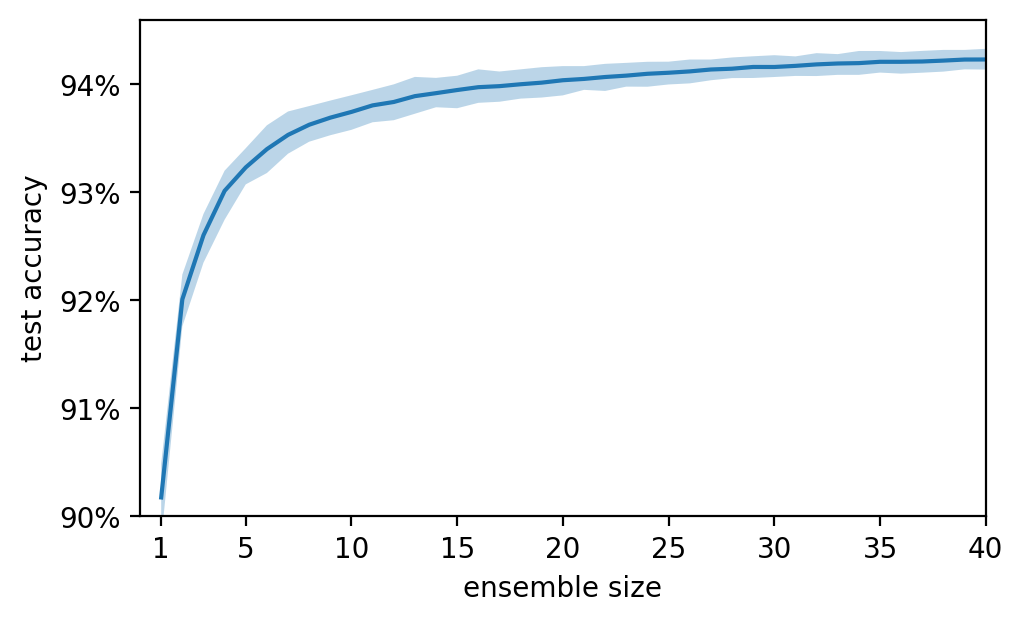

In [23]:
fig, ax = plt.subplots(figsize=(5, 3), layout='compressed')

n_plot = 40
n = 1 + jnp.arange(acc.shape[1])
ax.plot(n[:n_plot], acc.mean(0)[:n_plot])
ax.fill_between(n[:n_plot], jnp.quantile(acc, 0.1, axis=0)[:n_plot], jnp.quantile(acc, 0.9, axis=0)[:n_plot], alpha=0.3)

# log x scale
# ax.set_xscale('log')
# x_formatter = mpl.ticker.ScalarFormatter()
# x_formatter.set_scientific(False)
# ax.xaxis.set_major_formatter(x_formatter)

# y scale in percent
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')

ax.set_xlim((0, 40))
ax.set_ylim((0.9, 0.946))
# ax.axvline(16, ls='--', c='black')
ax.set_xticks(jnp.linspace(0, 40, 9).at[0].set(1))
ax.set_xlabel('ensemble size')
ax.set_ylabel('test accuracy')
plt.savefig('../plots/ensemble_size.pdf')
plt.show()